In [1]:
import csv 
import spacy
import tkinter as tk
from tkinter import filedialog
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

nlp = spacy.load("en_core_web_md")

In [3]:
# return list of sentences from dataset with duplicates eliminated 
# input format: [[int1,string],[int2,string],[int3,string]]
# output format: [sentence1,sentence2,sent....]
def process_data_from_csv(csv_reader):
    seen_sentences = set()
    result = []

    def get_sentences(text):
        sentences = text.split('. ')
        if sentences and sentences[-1].endswith('.'):
            sentences[-1] = sentences[-1][:-1]
        return sentences

    next(csv_reader, None)  # Skip header if present

    for row in csv_reader:
        text = row[1]  # second column contains the text

        sentences = get_sentences(text)
        for sentence in sentences:
            if sentence not in seen_sentences:
                seen_sentences.add(sentence)
                result.append(sentence)  

    return result

# Filters sentences by contextual relevance to keyword groups.
# Input - data: List of sentences, e.g., ["sentence1", "sentence2", ...]
# Input - keywords: List of keyword groups, e.g., [["word1", "word2"], ["word3"]]
# Output: List of lists, where each sublist corresponds to a keyword group.
#         Each sublist contains sentences matching the keywords of that group,
#         ensuring no sentence is repeated across different groups.
#         Non-matching positions within each group are filled with an empty string to maintain list consistency.
def filter_context_related_sentences(data, keyword_groups):
    # Initialize a list of lists for storage, corresponding to each keyword group
    categorized_sentences = [[] for _ in keyword_groups]
    target_tokens_groups = [[nlp(keyword) for keyword in group] for group in keyword_groups]

    # Process each sentence in the data
    count=0
    for sentence in data:
        print("Evaluating sentence",count,"...")
        count += 1
        doc = nlp(sentence)
        # Track which categories the sentence belongs to
        matched_indices = []

        for group_index, target_tokens in enumerate(target_tokens_groups):
            found = False
            for token in doc:
                for target_token in target_tokens:
                    if token.similarity(target_token) > 0.8:
                        matched_indices.append(group_index)
                        found = True
                        break
                if found:
                    break

        # Add the sentence to the matched categories
        for index in matched_indices:
            categorized_sentences[index].append(sentence)

    # Transpose the lists to align sentences across categories without gaps
    max_length = max(len(lst) for lst in categorized_sentences)
    for lst in categorized_sentences:
        lst.extend([""] * (max_length - len(lst)))  # Ensure all lists have the same length

    # Combine the lists such that there are no empty entries horizontally
    filtered_data = []
    for i in range(max_length):
        row = [categorized_sentences[group_index][i] for group_index in range(len(keyword_groups))]
        filtered_data.append(row)

    return filtered_data


# class to raise custom error
class InvalidInput(Exception):

    def __init__(self, message="Invalid input, restart program and re-enter"):
        self.message = message
        super().__init__(self.message)

# function to choose .csv(dataset file) via a dialog box
def choose_csv_file():
    root = tk.Tk()
    root.withdraw()  

    file_path = filedialog.askopenfilename(
        title="Select a CSV file",
        filetypes=[("CSV files", "*.csv")]
    )
    if file_path: 
        print(f"File selected: {file_path}")
    else:
        print("No file was selected.")

    return file_path

In [6]:
def visualizations():
    
    df = pd.read_csv('/home/hassan/CoherentComposer/clean_dataset.csv')
    
    total_records = len(df)
    
    column_non_null_counts = [df[col].count() for col in df.columns]
    
    plt.figure(figsize=(10, 6))
    counts = [total_records] + column_non_null_counts
    labels = ['Total Records'] + list(df.columns)
    
    plt.bar(labels, counts, color='skyblue')
    plt.xlabel('Columns')
    plt.ylabel('Number of Records')
    plt.title('Total Records in CSV and Each Column')
    plt.xticks(rotation=45)
    plt.tight_layout() 
    plt.show()
    
    for column in df.columns:
        df[column + '_wc'] = df[column].apply(lambda x: len(str(x).split()))
    
    # Heatmap of correlation matrix (if there are multiple numeric summaries)
    plt.figure(figsize=(10, 6))
    sns.heatmap(df.corr(), annot=True, cmap='coolwarm', linewidths=.5)
    plt.title('Correlation Matrix of Data')
    plt.show()

File selected: /home/hassan/CoherentComposer/Cleaned Data Sets_1/Mistral7B_CME_v1.csv
Evaluating sentence 0 ...


/tmp/ipykernel_3279/1540955581.py:52: UserWarning: [W008] Evaluating Token.similarity based on empty vectors.
  if token.similarity(target_token) > 0.8:


Evaluating sentence 1 ...
Evaluating sentence 2 ...
Evaluating sentence 3 ...
Evaluating sentence 4 ...
Evaluating sentence 5 ...
Evaluating sentence 6 ...
Evaluating sentence 7 ...
Evaluating sentence 8 ...
Evaluating sentence 9 ...
Evaluating sentence 10 ...
Evaluating sentence 11 ...
Evaluating sentence 12 ...
Evaluating sentence 13 ...
Evaluating sentence 14 ...
Evaluating sentence 15 ...
Evaluating sentence 16 ...
Evaluating sentence 17 ...
Evaluating sentence 18 ...
Evaluating sentence 19 ...
Evaluating sentence 20 ...
Evaluating sentence 21 ...
Evaluating sentence 22 ...
Evaluating sentence 23 ...
Evaluating sentence 24 ...
Evaluating sentence 25 ...
Evaluating sentence 26 ...
Evaluating sentence 27 ...
Evaluating sentence 28 ...
Evaluating sentence 29 ...
Evaluating sentence 30 ...
Evaluating sentence 31 ...
Evaluating sentence 32 ...
Evaluating sentence 33 ...
Evaluating sentence 34 ...
Evaluating sentence 35 ...
Evaluating sentence 36 ...
Evaluating sentence 37 ...
Evaluating

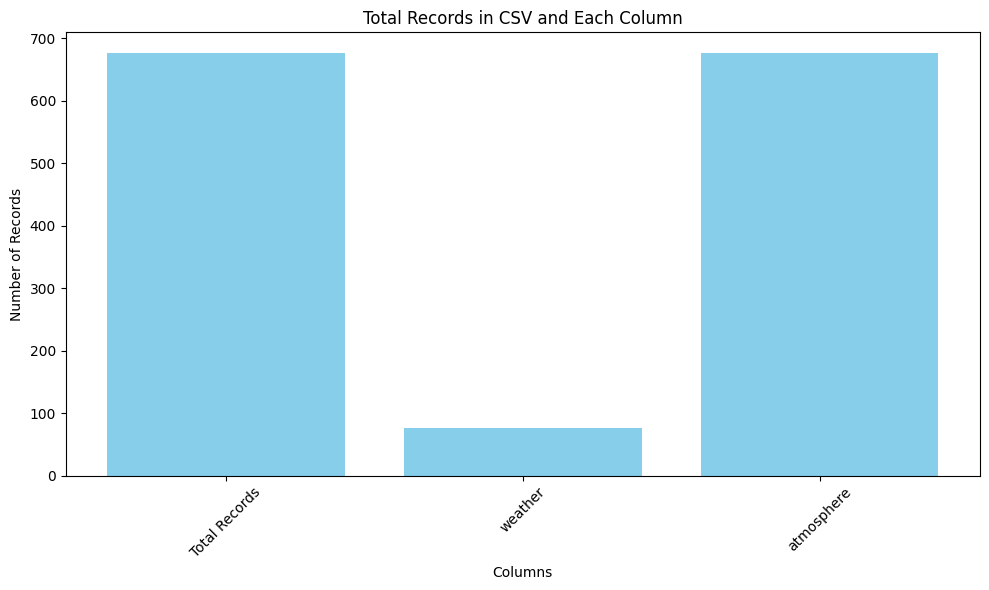

/tmp/ipykernel_3279/272153622.py:26: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), annot=True, cmap='coolwarm', linewidths=.5)


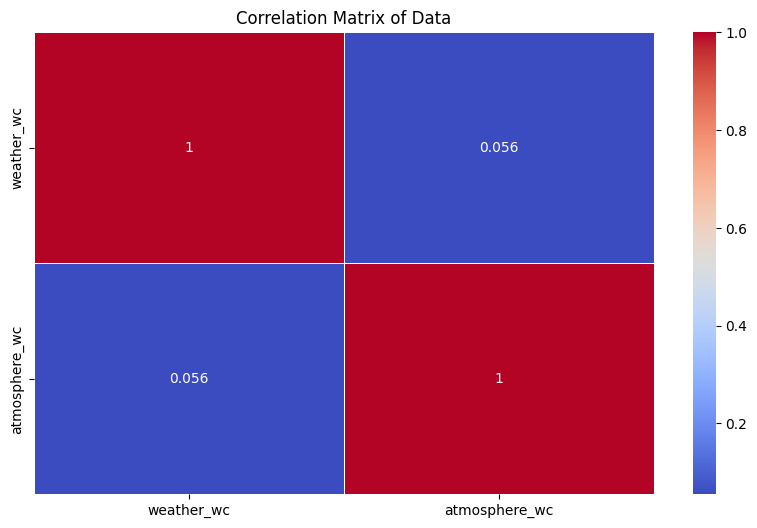

In [7]:
keywords = []
# Input number of categories for data extraction
numCategories = int(input("How many categories would you like your data extracted into? "))

# Input keyword(s) for each category
for x in range(numCategories):
    category = input("Enter keyword(s) for category "+ str(x+1) + " seperated by commas")
    category = category.split(",")
    keywords.append(category)

# Ensure user has left input empty 
if(keywords ==[] or [""] in keywords):
    raise InvalidInput()

# Select input/dataset/.csv file
selected_file = choose_csv_file()

# Create list of column headings for output .csv file
column_headings = []
for category in keywords:
    column_headings.append(category[0])

# read raw data from .csv/dataset
with open(selected_file, 'r') as file:
    csv_reader = csv.reader(file)
    next(csv_reader)  
    data = process_data_from_csv(csv_reader) 

filtered_data = filter_context_related_sentences(data,keywords)

with open('clean_dataset.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(column_headings)  
    writer.writerows(filtered_data)

print("Data has been written to clean_dataset.csv successfully.")

visualizations()

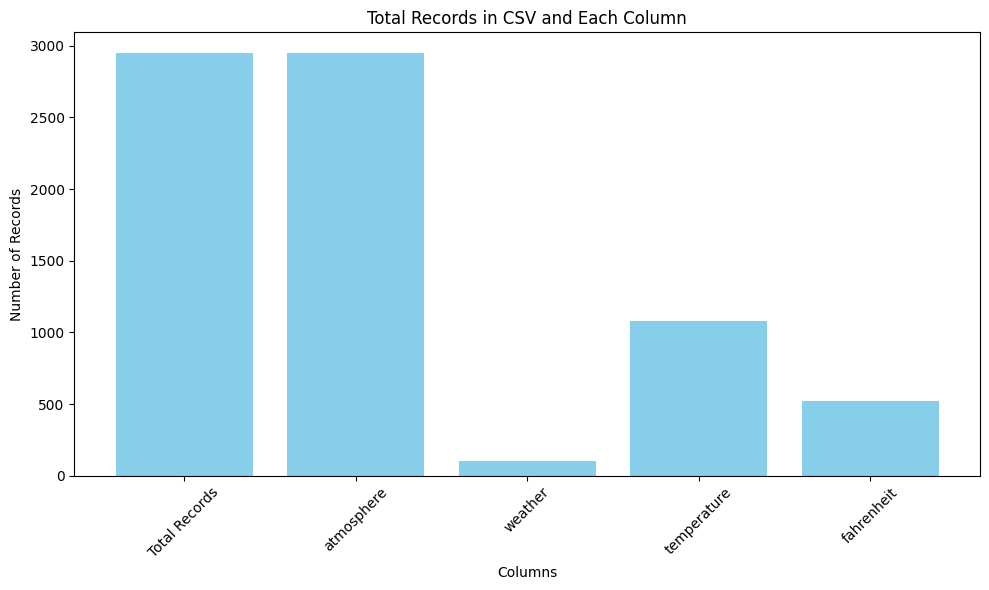

/tmp/ipykernel_324226/1977902694.py:45: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), annot=True, cmap='coolwarm', linewidths=.5)


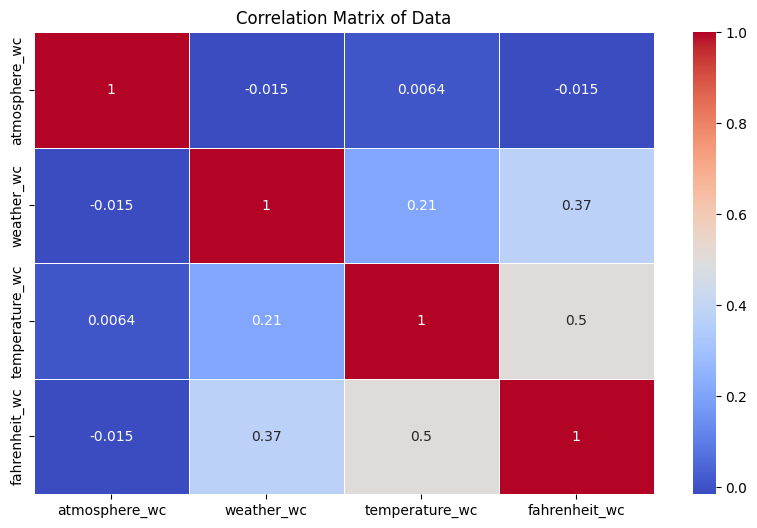

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('/home/hassan/CoherentComposer/clean_dataset.csv')

total_records = len(df)

column_non_null_counts = [df[col].count() for col in df.columns]

plt.figure(figsize=(10, 6))
counts = [total_records] + column_non_null_counts
labels = ['Total Records'] + list(df.columns)

plt.bar(labels, counts, color='skyblue')
plt.xlabel('Columns')
plt.ylabel('Number of Records')
plt.title('Total Records in CSV and Each Column')
plt.xticks(rotation=45)
plt.tight_layout() 
plt.show()

for column in df.columns:
    df[column + '_wc'] = df[column].apply(lambda x: len(str(x).split()))

# plt.figure(figsize=(10, 6))
# column_wc = [df[col].count() for col in df.columns]
# plt.bar(df.columns, column_wc, color='skyblue')
# plt.xlabel('Columns')
# plt.ylabel('Number of Records')
# plt.title('Total Records in Each Column')
# plt.xticks(rotation=45)
# plt.show()

# # Additional Visualizations
# # Histogram of word counts if the data is textual
# plt.figure(figsize=(10, 6))
# sns.histplot(df['atmosphere_wc'], color='purple', kde=True)
# plt.title('Word Count Distribution for Atmosphere Descriptions')
# plt.xlabel('Word Count')
# plt.show()

# Heatmap of correlation matrix (if there are multiple numeric summaries)
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', linewidths=.5)
plt.title('Correlation Matrix of Data')
plt.show()